In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,MaxPooling2D)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
import matplotlib.pyplot as plt 

from keras.preprocessing import image
from keras.layers import merge, Input
from keras.utils import np_utils
import os
import time

import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
SEED=2

train=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
submition=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv")

x = train['id_code']
y = train['diagnosis']

x,y=shuffle(x,y)
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
df_X,X_test,df_y,y_test=train_test_split(x, y, test_size=0.15)

X_train,X_valid,y_train,y_valid=train_test_split(df_X, df_y, test_size=0.15)

# Number of samples in each class

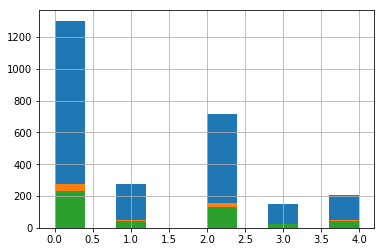

In [3]:
y_train.hist()
y_test.hist()
y_valid.hist()

- Train(Blue) 
- Test (Yellow)
- Valid(Green)

# Images befor pre processing

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


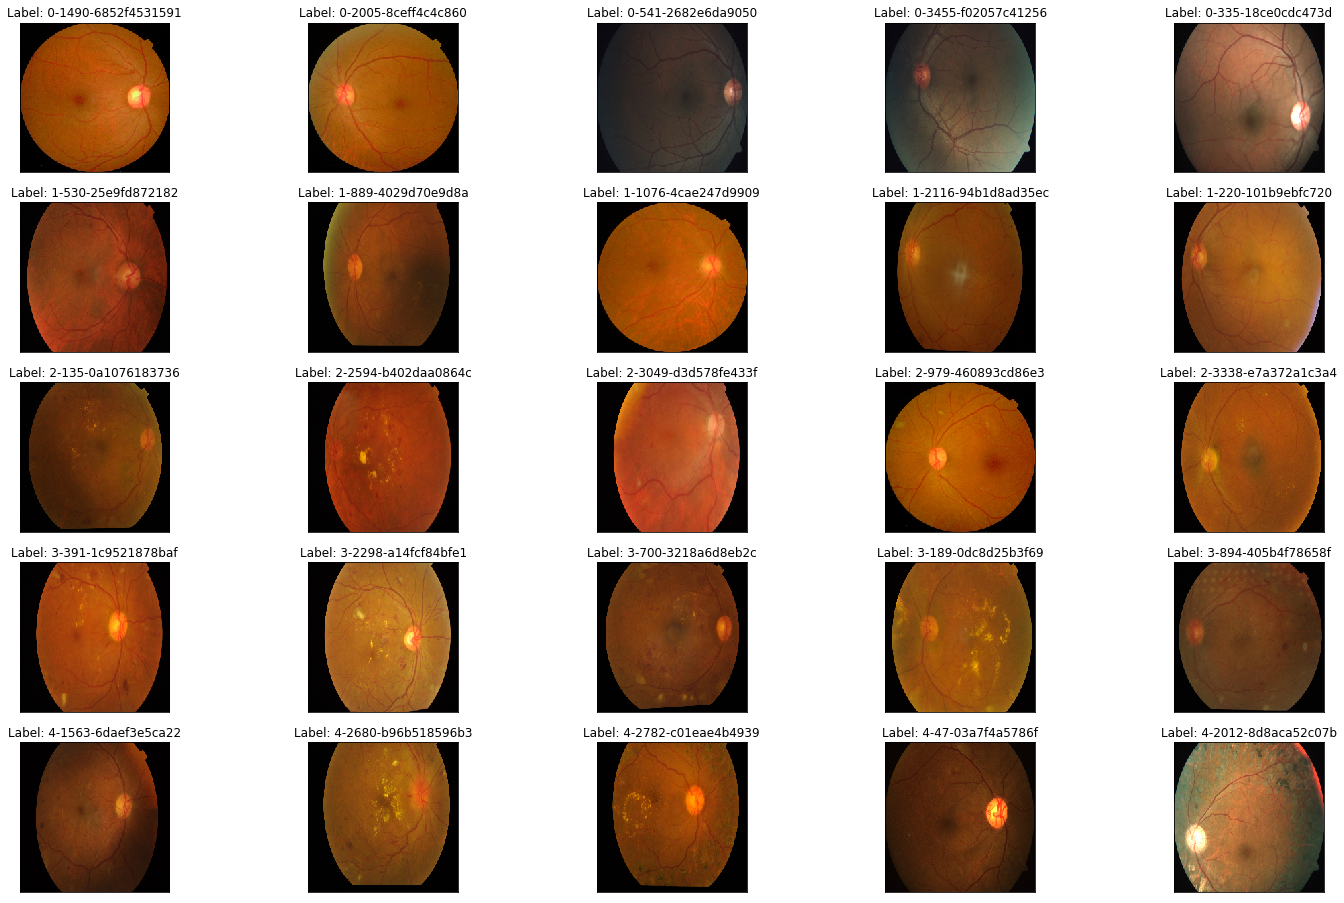

In [4]:

%time
IMG_SIZE=224
#IMG_SIZE=300
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [5]:
def load_ben_color(path, sigmaX=20):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [6]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [7]:

train_images=[]

%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_train):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    train_images.append(image)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.3 µs


<Figure size 1800x1152 with 0 Axes>

# After preProcessing

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


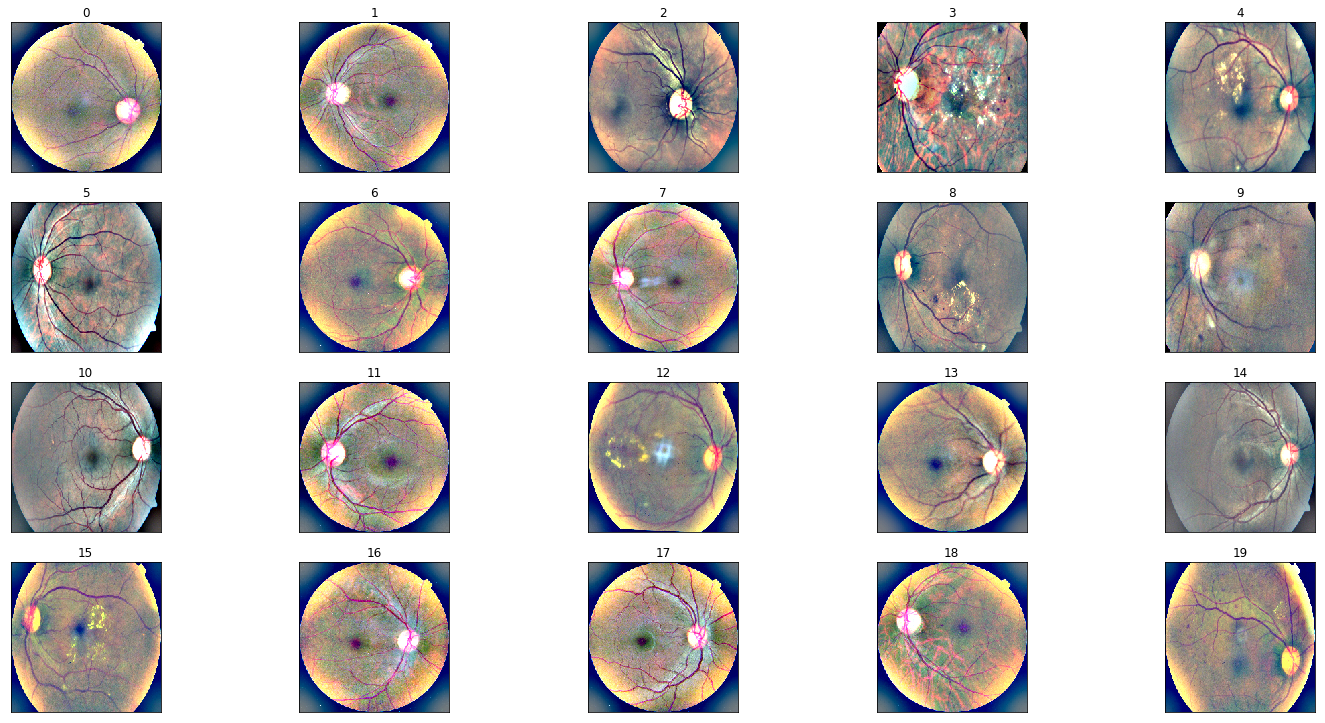

In [8]:
%time
fig = plt.figure(figsize=(25, 16))
for i in range(0,20):
    ax = fig.add_subplot(5, 5, 5 + i + 1, xticks=[], yticks=[])
    #path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
    image = train_images[i]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

    plt.imshow(image)
    ax.set_title(i)

In [9]:
import matplotlib.pyplot as plt 
import cv2
test_images=[]

%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_test):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    test_images.append(image)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


<Figure size 1800x1152 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt 
import cv2
valid_images=[]

%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_valid):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    valid_images.append(image)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


<Figure size 1800x1152 with 0 Axes>

In [11]:
from keras.utils import to_categorical
NUM_CLASSES=5
y_train_dummies=to_categorical(y_train,num_classes=NUM_CLASSES)
y_test_dummies=to_categorical(y_test,num_classes=NUM_CLASSES)
y_valid_dummies=to_categorical(y_valid,num_classes=NUM_CLASSES)
y_train_dummies

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [12]:
num_Classes=5

train=np.array(train_images)
test=np.array(test_images)
valid=np.array(valid_images)

num_of_samples=train.shape[0]
train.shape

(2645, 224, 224, 3)

In [13]:
#Importing the vgg16 model

from keras.applications.vgg16 import VGG16, preprocess_input
#Loading the vgg16 model with pre-trained ImageNet weights
premodel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [14]:
#Reshaping the testing data
test=np.array(test_images)

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_test_input = preprocess_input(test)

#Creating bottleneck features for the testing data
test_features = premodel.predict(resnet_test_input)

#Saving the bottleneck features
np.savez('../working/vgg16_features_test', features=test_features)

In [15]:
#Reshaping the testing data
train=np.array(train_images)

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_train_input = preprocess_input(train)

#Creating bottleneck features for the testing data
train_features = premodel.predict(resnet_train_input)

#Saving the bottleneck features
np.savez('../working/vgg16_features_train', features=train_features)

In [16]:
#Reshaping the testing data
valid=np.array(valid_images)

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_valid_input = preprocess_input(valid)

#Creating bottleneck features for the testing data
valid_features = premodel.predict(resnet_valid_input)

#Saving the bottleneck features
np.savez('../working/vgg16_features_valid', features=valid_features)

In [17]:


# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_features)
datagen_valid.fit(valid_features)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2645, 7, 7, 512) (512 channels).
  ' channels).')
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (467, 7, 7, 512) (512 channels).
  ' channels).')


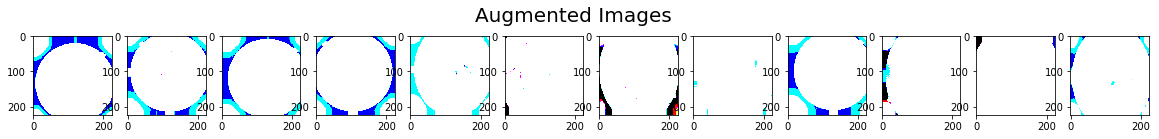

In [18]:

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = train[:12]
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [19]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 530,437
Trainable params: 530,437
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss="categorical_crossentropy", optimizer='Adam',  metrics=['accuracy'])

In [21]:
batch_size=32
t=time.time()

model.fit_generator(datagen_train.flow(train_features, y_train_dummies, batch_size=batch_size),
                    steps_per_epoch=train.shape[0]/32,
                    epochs=2, verbose=2,
                    validation_data=datagen_valid.flow(valid_features, y_valid_dummies, batch_size=batch_size),validation_steps=valid.shape[0]/32)
print("training time: %s" %(t-time.time()))

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2645, 7, 7, 512) (512 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (467, 7, 7, 512) (512 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/2
 - 65s - loss: 3.1234 - accuracy: 0.6042 - val_loss: 1.2468 - val_accuracy: 0.7430
Epoch 2/2
 - 63s - loss: 1.2342 - accuracy: 0.6662 - val_loss: 0.4433 - val_accuracy: 0.7559
training time: -128.01992750167847


In [22]:
batch_size = 32
epochs = 20


t=time.time()
checkpointer = ModelCheckpoint(filepath='../working/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)
model.fit_generator(datagen_train.flow(train_features, y_train_dummies, batch_size=batch_size),
                    steps_per_epoch=train.shape[0]/16,
                    epochs=epochs, verbose=2,
                    callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_features, y_valid_dummies, batch_size=batch_size),validation_steps=valid.shape[0]/16)
print("training time: %s" %(t-time.time()))

Epoch 1/20


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2645, 7, 7, 512) (512 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (467, 7, 7, 512) (512 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


 - 125s - loss: 0.8197 - accuracy: 0.6940 - val_loss: 0.4300 - val_accuracy: 0.7537

Epoch 00001: val_loss improved from inf to 0.42998, saving model to ../working/weights.best.from_scratch.hdf5
Epoch 2/20
 - 120s - loss: 0.7370 - accuracy: 0.7261 - val_loss: 0.5839 - val_accuracy: 0.7527

Epoch 00002: val_loss did not improve from 0.42998
Epoch 3/20
 - 119s - loss: 0.7048 - accuracy: 0.7306 - val_loss: 0.5971 - val_accuracy: 0.7666

Epoch 00003: val_loss did not improve from 0.42998
Epoch 4/20
 - 119s - loss: 0.6942 - accuracy: 0.7352 - val_loss: 0.5787 - val_accuracy: 0.7452

Epoch 00004: val_loss did not improve from 0.42998
Epoch 5/20
 - 120s - loss: 0.6764 - accuracy: 0.7355 - val_loss: 0.3891 - val_accuracy: 0.7645

Epoch 00005: val_loss improved from 0.42998 to 0.38912, saving model to ../working/weights.best.from_scratch.hdf5
Epoch 6/20
 - 120s - loss: 0.6616 - accuracy: 0.7429 - val_loss: 0.7751 - val_accuracy: 0.7709

Epoch 00006: val_loss did not improve from 0.38912
Epoch 7

In [30]:
model.load_weights('../working/weights.best.from_scratch.hdf5')

In [31]:
(loss, accuracy)=model.evaluate(test_features,y_test_dummies,verbose=1 ,batch_size=32)
print(loss)
print(accuracy*100)

550/550 [==============================] - 0s 107us/step
0.528927405395291
79.81818318367004


In [25]:

submit_images=[]

%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(submition['id_code']):
    
    path=f"../input/aptos2019-blindness-detection/test_images/"+row+".png"
   
    image =load_ben_color(path)
    submit_images.append(image)
submit_image=np.array(submit_images)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


<Figure size 1800x1152 with 0 Axes>

In [26]:

submit=np.array(submit_image)

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_submit_input = preprocess_input(submit)

#Creating bottleneck features for the testing data
submit_features = premodel.predict(resnet_submit_input)

#Saving the bottleneck features
np.savez('../working/vgg16_features_submit', features=submit_features)

In [27]:
predictions = [str(np.argmax(model.predict(np.expand_dims(tensor, axis=0)))) for tensor in submit_features]

In [28]:
submition['diagnosis'] = predictions
submition.to_csv('submission.csv', index=False)
submition.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,3


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


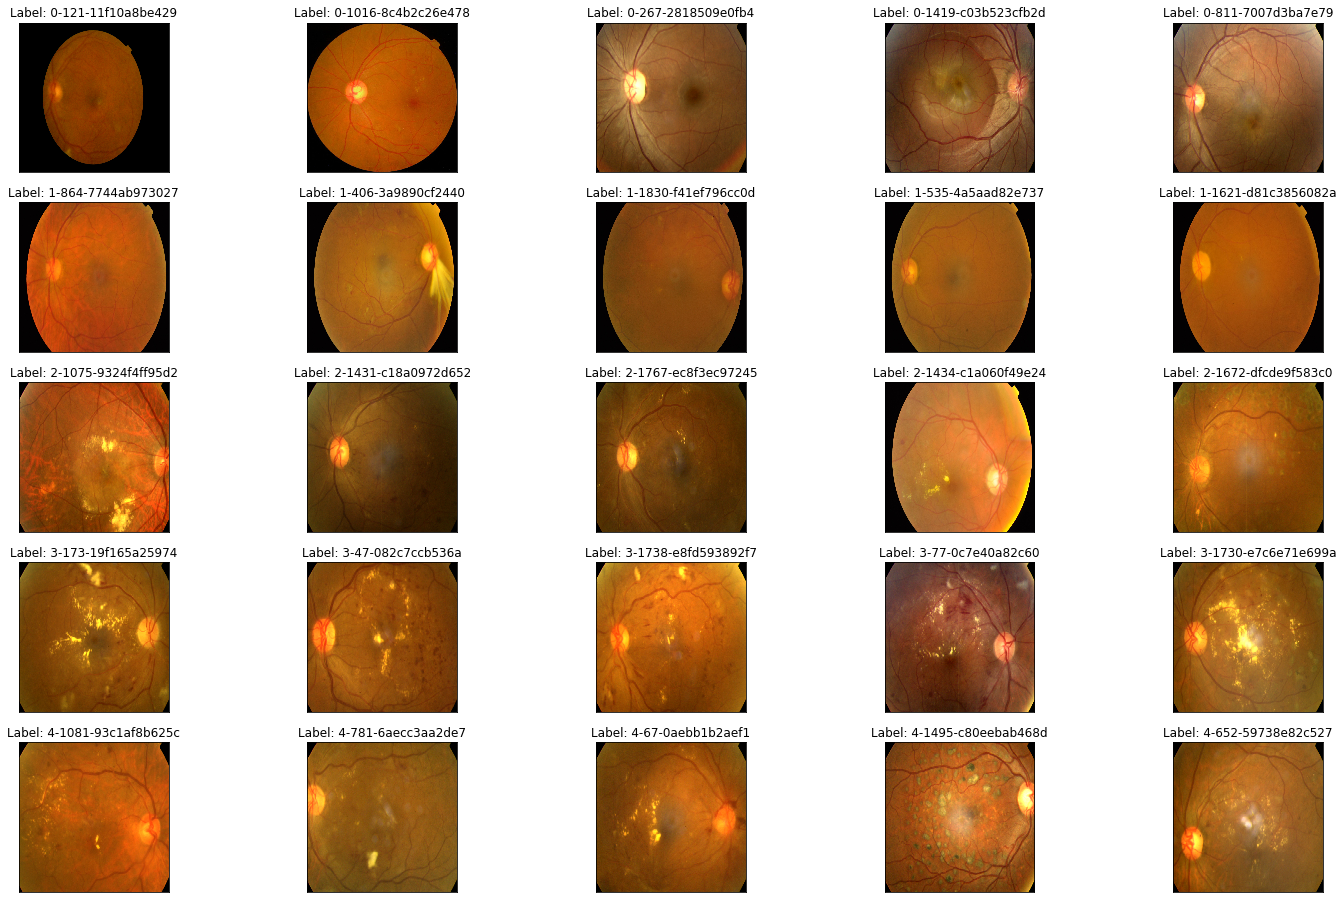

In [29]:
%time
IMG_SIZE=300
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(submition['diagnosis'].unique()):
    for i, (idx, row) in enumerate(submition.loc[submition['diagnosis'] == class_id].sample(5, random_state=2).iterrows()):
        ax = fig.add_subplot(5, 5, int(class_id) * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/test_images/"+row['id_code']+".png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (int(class_id), idx, row['id_code']) )